In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm

import tensorflow as tf
import numpy as np
import random
import os
from glob import glob
import time, datetime

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
%load_ext tensorboard

In [15]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Scaling Up our CNN Model

From here onwards we're going to use the full 101 of food classes,
using splitting them from 75% - 25% train and test chronologically,
and generating 10% of the data from the train set.

What we're left of is 101 classes with 75 images each for the train set and 250 images for the test set.

### Parsing through the data

In [16]:
train_101_dir = './Food-Vision-REDO/datasets/food_101/train/'
train_101_10_dir = './Food-Vision-REDO/datasets/food_101/train_10/'
test_101_dir = './Food-Vision-REDO/datasets/food_101/test/'
food_101_dir = './Food-Vision-REDO/datasets/food_101/'


In [17]:
class_list_all = glob(os.path.join(train_101_dir, '*',))
class_list_all = [i.split('\\')[-1] for i in class_list_all]
class_list_all;
len(class_list_all)

101

In [18]:
def plot_random_image(class_list, directory):
    
    '''
    Takes in a list of classes which randomly selects an image in its directory
    
    
    Parameters
    --------
    class_list - list of classes(similar to its folder name)
    directory - location of images you would want to view
    '''
    
    random_class = random.choice(class_list)
    random_dir = directory + random_class
    random_img = random.choice(os.listdir(random_dir))
    rng_dir_img = random_dir + '/' + random_img
    arr_dir_img = mpimg.imread(rng_dir_img)
    
    img=plt.imshow(arr_dir_img)
    plt.axis(False)
    plt.title(f'class:{random_class}\n shape:{arr_dir_img.shape}\n {random_img}')
    return img

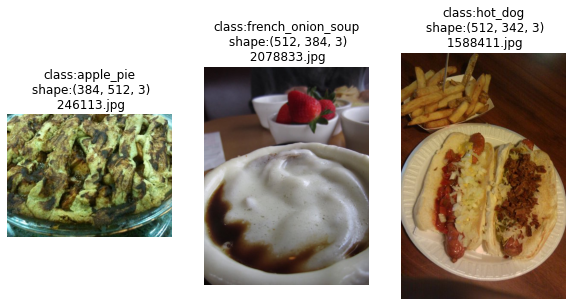

In [19]:
plt.figure(figsize=(10,10))
for i in range(1,4):
    plt.subplot(1,3,i)
    plot_random_image(class_list=class_list_all, directory=train_101_dir)

In [20]:
IMG_SIZE=(224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_101_10_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_101_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    shuffle=False
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Generating a checkpoint callback

In [21]:
def create_checkpoint_callback(checkpoint_path, metric):
    '''
    creates a checkpoint callback
    
    Parameters
    -----
    checkpoint_path - destination file path
    '''
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor=metric,
        save_weights_only=True,
        save_best_only=True,
    )
    return checkpoint_callback

In [28]:
chck_pth = './Food-Vision-REDO/checkpoint/checkpoint.ckpt'
checkpoint_callback = create_checkpoint_callback(chck_pth, metric='accuracy')

### Building our Baseline Model - Model 0 Feature Extraction

In [22]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2)
], name = 'data_augmentation')

In [23]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE+(3,), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
outputs = tf.keras.layers.Dense(len(class_list_all), activation='softmax', name='output_layer')(x)

model_0 = tf.keras.Model(inputs, outputs)


In [24]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling (GlobalA  (None, 1280)             0         
 veragePooling2D)                                                
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])

model_0_history = model_0.fit(
    train_data_all_10_percent,
    epochs=5,
    validation_data=test_data,
    validation_steps=int(.15*len(test_data)),
    callbacks=[checkpoint_callback]
)

Epoch 1/5
 61/237 [======>.......................] - ETA: 1:10 - loss: 4.2437 - accuracy: 0.1060

In [ ]:
all_classes_10_percent = model_0.evaluate(test_data)
all_classes_10_percent

In [ ]:
plot_history_curves(model_0_history)

In [ ]:
### Fine Tuning - Model 1

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-5]:
    layer.trainable = False
    
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       metrics=['accuracy'])

for layer in model_0.layers:
    print(layer.name, layer.trainable)

In [ ]:
model_0.summary()

In [ ]:
for layer_number, layer in enumerate(model_0.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

In [ ]:
> 🔑 for fine tuning, fine tune layer by layer in increments
when unfreezing layers increase `learning rates`

In [ ]:
len(model_0_history.epoch)

In [ ]:
model_1_history = model_0.fit(
    train_data_all_10_percent,
    epochs=len(model_0_history.epoch)+5,
    initial_epoch=model_0_history.epoch[-1],
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    callbacks=[checkpoint_callback]
)

In [ ]:
all_classes_10_percent_tuned = model_0.evaluate(test_data)
all_classes_10_percent_tuned

In [ ]:
compare_history(model_0_history, model_1_history, initial_epochs=5)

In [ ]:
### Saving and loading our model [Postponed until fixed]

loading a model with hd5 file is slightly different that the model at hand
saving a model compiled with regular .tf file isn't working and causes an error when done so

In [ ]:
#model_0.save(filepath='./Food-Vision-REDO/models/101_food_class_10_percent_model')

In [ ]:
# loaded_model = tf.keras.models.load_model('./Food-Vision-REDO/models/101_food_class_10_percent_model.h5')
# loaded_model.trainable = True

# for layer in loaded_model.layers[2].layers[:-5]:
#     layer.trainable = False
        
# loaded_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
#                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#                        metrics=['accuracy'])

# loaded_model_history = loaded_model.fit(
#     train_data_all_10_percent,
#     epochs=len(model_0_history.epoch)+5,
#     initial_epoch=model_0_history.epoch[-1],
#     validation_data=test_data,
#     validation_steps=int(0.15*len(test_data)),
#     callbacks=[checkpoint_callback]
# )

In [ ]:
# loaded_model_results = loaded_model.evaluate(test_data)
# loaded_model_results

In [ ]:
#for layer in loaded_model.layers:
#    print(layer.name, layer.trainable)

In [ ]:
#for layer_number, layer in enumerate(loaded_model.layers[2].layers):
#    print(layer_number, layer.name, layer.trainable)

In [ ]:
#loaded_model.summary()

In [ ]:
model_0.evaluate(test_data)

In [ ]:
pred_probs = model_0.predict(test_data, verbose=1)

In [ ]:
pred_probs.shape

In [ ]:
pred_probs[0], len(pred_probs[0]), sum(pred_probs[0])

In [ ]:
print(f'Number of prediction probability for sample 0:{len(pred_probs[0])}') 
print(f'What Prediction Probability sample 0 looks like: \n{pred_probs[0]}')
print(f'What class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}')

In [ ]:
test_data.class_names[0]

In [ ]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

In [ ]:
len(pred_classes)

In [ ]:
y_labels = []

for images, labels in tqdm(test_data.unbatch()):
        y_labels.append(labels.numpy().argmax())
        
y_labels[:10]

In [ ]:
len(y_labels)

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
      y_true: Array of truth labels (must be same shape as y_pred).
      y_pred: Array of predicted labels (must be same shape as y_true).
      classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
      figsize: Size of output figure (default=(10, 10)).
      text_size: Size of output figure text (default=15).
      norm: normalize values or not (default=False).
      savefig: save confusion matrix to file (default=False).

    Returns:
      A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    """
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),  # create enough axis slots for each class
           yticks=np.arange(n_classes),
           xticklabels=labels,  # axes will labeled with class names (if they exist) or ints
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    plt.xticks(rotation=90)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true=y_labels, y_pred=pred_classes, classes=class_list_all, figsize=(100,100), text_size=20)
